In [260]:
import itertools
import os
import re
#import dill as pickle
import pickle
import numpy as np
import matplotlib.pyplot as plt
plt.warnings.filterwarnings("ignore")
from collections import defaultdict, namedtuple
from urllib.request import urlopen
from bs4 import BeautifulSoup
from scipy.spatial.distance import cosine
from scipy.stats import spearmanr, pearsonr
from sklearn.metrics.pairwise import cosine_similarity
import math
from scipy import stats
import statsmodels.formula.api as smf

# Load data

In [407]:
dir_ = '/home/sashkamilic/pretrained-vectors/eng-all/'
changes = pickle.load(open(dir_ + 'volstats/disps.pkl', 'rb'), encoding='latin1')
freqs = pickle.load(open(dir_ + 'freqs.pkl', 'rb'), encoding='latin1')
poly = pickle.load(open(dir_ + 'netstats/full-nstop_nproper-top10000.pkl', 'rb'), encoding='latin1')

In [408]:
START_YEAR = 1900

In [409]:
# scraping Swadesh words

SWADESH = {}

pattern = re.compile(r'\d+ \*?([A-Za-z]+) \(([0-9]{1,2}\.[0-9])\)')
url = "https://en.wikipedia.org/wiki/Swadesh_list"
page = urlopen(url)
soup = BeautifulSoup(page, 'html.parser')
div_ranked = soup.find_all('div', attrs={'class': 'div-col columns column-count column-count-5'})[1]
for li in div_ranked.ol.find_all('li'):
    text = li.text
    m = pattern.match(text)
    SWADESH[m.group(1)] = float(m.group(2))

# remove infrequent words
keys_ = list(SWADESH.keys())
for w in keys_:
    if w not in changes or math.isnan(changes[w][1900]) or math.isnan(changes[w][1990]):
        print('removed {}'.format(w.upper()))
        del SWADESH[w]

removed LOUSE
removed I
removed YOU
removed WE
removed GREASE
removed WHAT
removed CLAW
removed WHO
removed NOT
removed THIS
removed THAT
removed ALL


### Set up dataframe

In [433]:
import pandas as pd

words = list(changes.keys())

data = np.ndarray(shape=(10000,5), dtype=float)
data[:,0] = np.array([np.arccos(changes[w][START_YEAR]) for w in words])
data[:,1] = np.array([1 if w in SWADESH else 0 for w in words])
#data[:,2] = np.array([np.mean([f for year,f in freqs[w].items() if YEAR <= year and year <= 1990 ]) for w in words])
data[:,2] = np.array([freqs[w][START_YEAR] for w in words])
#data[:,2] = np.log(data[:,2])
#data[:,3] = np.array([np.mean([p for year,p in poly['bclust'][w].items() if YEAR <= year and year <= 1990 ]) for w in words])
data[:,3] = np.array([-1 * poly['bclust'][w][START_YEAR] for w in words])
#data[:,3] = -np.log(data[:,3])
data[:,4] = data[:,1] * data[:,2] # interaction between frequency and Swadesh

df = pd.DataFrame(data, columns=['change', 'is_swadesh', 'freq', 'poly', 'freq_swadesh'])

# Q1: Do Swadesh words change less (between the 1900s and 1990s) than non-Swadesh words?

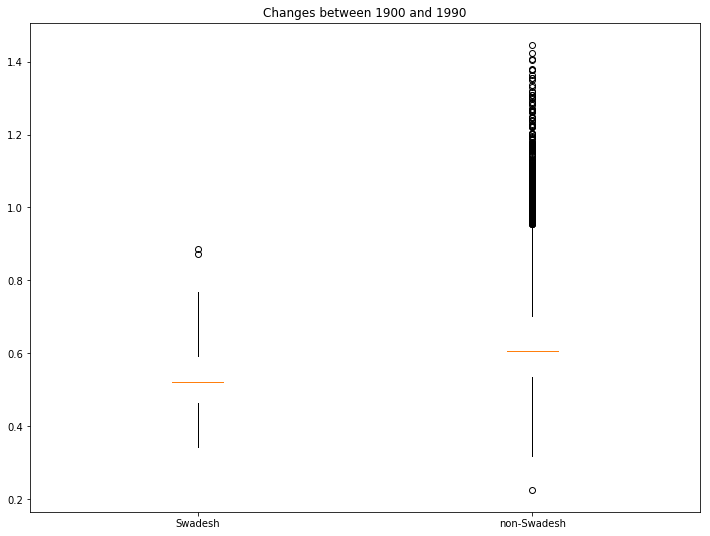

In [411]:
change_swa = df['change'].mask(~df['is_swadesh'].astype('bool')).dropna()
change_non = df['change'].mask(df['is_swadesh'].astype('bool')).dropna()

plt.boxplot([change_swa, change_non], labels=['Swadesh', 'non-Swadesh'], showbox=False, showcaps=False)
plt.title('Changes between 1900 and 1990')
plt.show()

In [412]:
st, p = stats.ttest_ind(change_swa, change_non, equal_var=False, nan_policy='omit')

print("mean change of Swadesh words:\n{:.4}".format(np.nanmean(change_swa)))
print("mean change of non-Swadesh words:\n{:.4}".format(np.nanmean(change_non)))
print("p-value: {:.4}".format(p))

mean change of Swadesh words:
0.5375
mean change of non-Swadesh words:
0.6341
p-value: 3.45e-13


# Q1b: Does this change remain after controlling for frequency and polysemy?

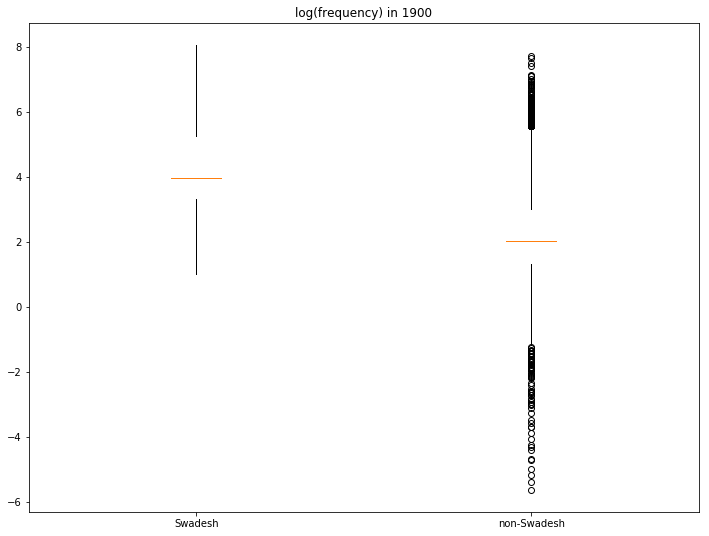

In [413]:
freq_swa = df['freq'].mask(~df['is_swadesh'].astype('bool')).dropna()
freq_non = df['freq'].mask(df['is_swadesh'].astype('bool')).dropna()

plt.boxplot([np.log(freq_swa*1e6), np.log(freq_non*1e6)], labels=['Swadesh', 'non-Swadesh'], showbox=False, showcaps=False)
plt.title('log(frequency) in 1900')
plt.show()

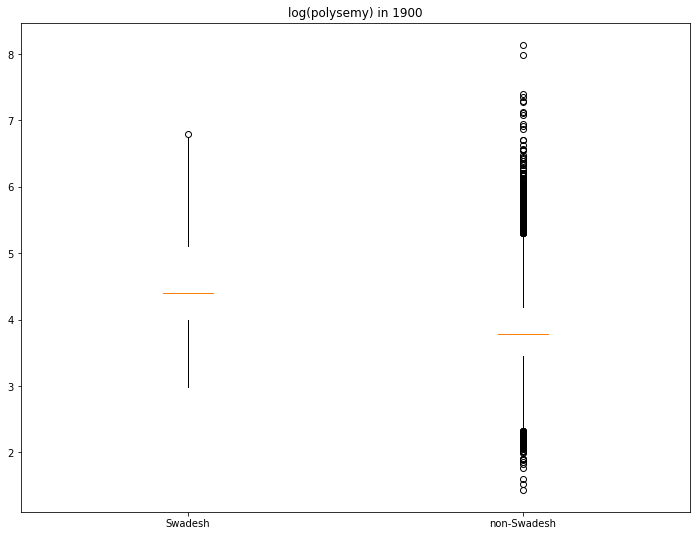

In [414]:
poly_swa = df['poly'].mask(~df['is_swadesh'].astype('bool')).dropna()
poly_non = df['poly'].mask(df['is_swadesh'].astype('bool')).dropna()

plt.boxplot([-np.log(-poly_swa), -np.log(-poly_non)], labels=['Swadesh', 'non-Swadesh'], showbox=False, showcaps=False)
plt.title('log(polysemy) in 1900')
plt.show()

In [700]:
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
import pandas as pd
    

print('Correlation matrix\n')
print(df.corr(method="spearman"))

# test significance
"""
labels = ['change', 'is_swadesh', 'freq', 'poly', 'interaction']
for i in range(5):
    for j in range(i+1):
        print(labels[i], labels[j])
        print(spearmanr(df[labels[i]], df[labels[j]], nan_policy='omit').pvalue)
#"""

print("\nTest for multicollinearity")
print("using the variance inflation factor (VIF); should be < 5.")
data_ = data[~np.isnan(data).any(axis=1)]
print(vif(data_, 0))
print(vif(data_, 1))
print(vif(data_, 2))
print(vif(data_, 3))
print(vif(data_, 4))


model = smf.ols(formula="change ~ freq + is_swadesh + freq_swadesh", data=df).fit()
print(model.summary())

model = smf.ols(formula="change ~ freq + poly + is_swadesh", data=df).fit()
print(model.summary())

Correlation matrix

                change  is_swadesh      freq      poly  freq_swadesh
change        1.000000   -0.068083 -0.173556  0.030409     -0.068156
is_swadesh   -0.068083    1.000000  0.109865  0.084979      0.999987
freq         -0.173556    0.109865  1.000000  0.639757      0.110132
poly          0.030409    0.084979  0.639757  1.000000      0.085273
freq_swadesh -0.068156    0.999987  0.110132  0.085273      1.000000

Test for multicollinearity
using the variance inflation factor (VIF); should be < 5.
3.2522951936184996
1.2662169144705702
1.4400432497820521
3.015418406250194
1.564402563978904
                            OLS Regression Results                            
Dep. Variable:                 change   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     51.66
Date:                Wed, 11 Apr 2018   Prob (F-statistic):           4

SpearmanrResult(correlation=0.09938008523827975, pvalue=0.3569349330299191)

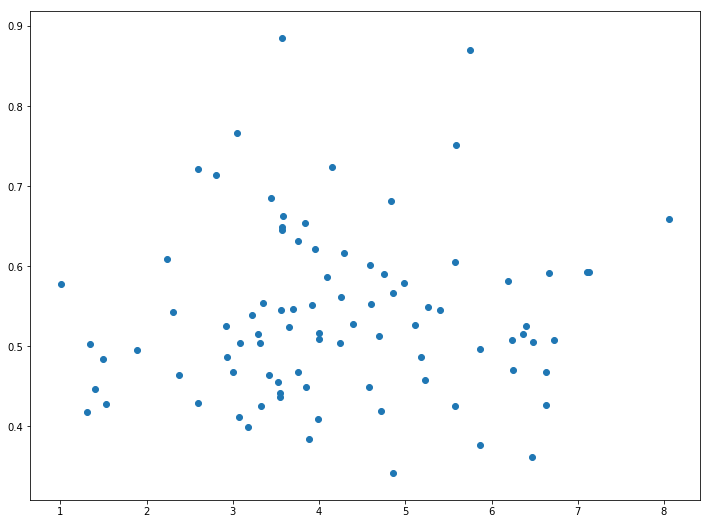

In [446]:
logfreq_swa = np.log(1e6*freq_swa)
plt.scatter(logfreq_swa, change_swa)
spearmanr(logfreq_swa, change_swa)

SpearmanrResult(correlation=0.07967313585291115, pvalue=0.4605825719493267)

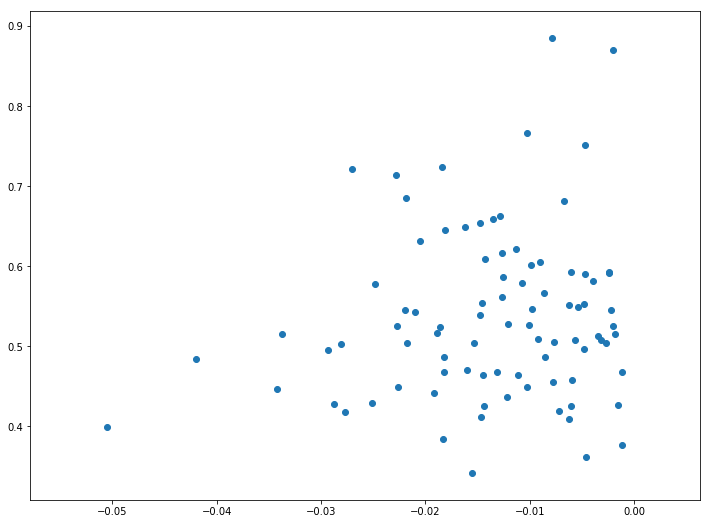

In [447]:
plt.scatter(poly_swa, change_swa)
spearmanr(poly_swa, change_swa)

## Q2: Is there a correlation between these "changes" and the stability measure?
(Stability: Holman et al., 2008)

In [687]:
swa = list(SWADESH.keys())
change_swa = np.array([np.arccos(changes[w][1900]) for w in swa])
stability_swa = np.array([SWADESH[w] for w in swa])

spearmanr(change_swa, stability_swa)

SpearmanrResult(correlation=-0.026541269321863778, pvalue=0.8060983904662611)

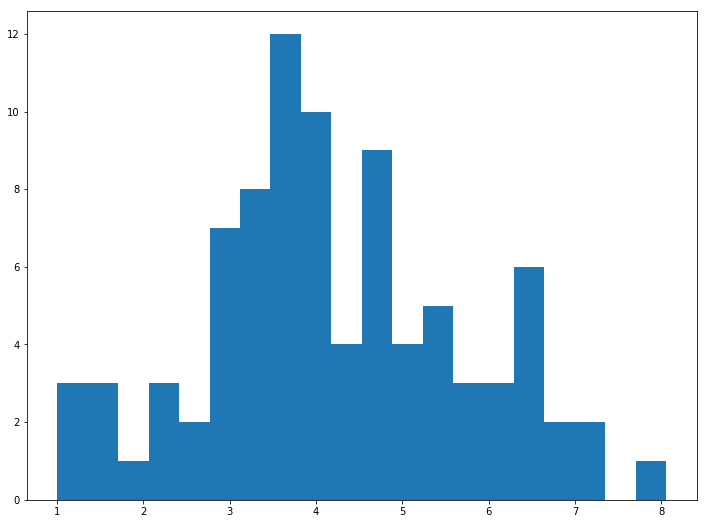

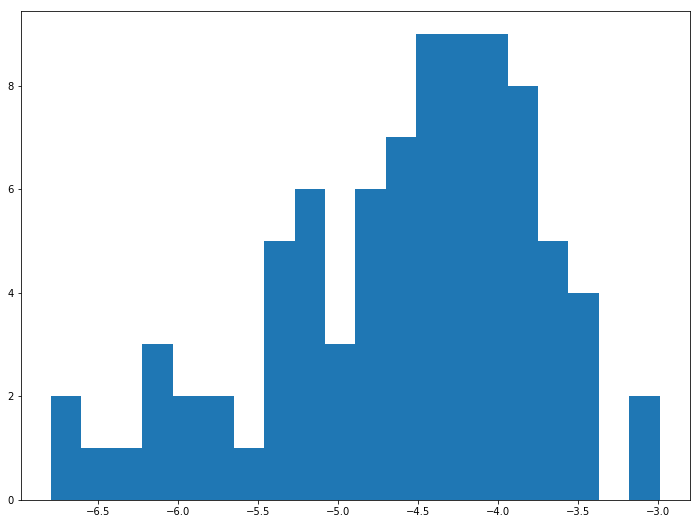

In [756]:
# creating set of data with same distribution
plt.hist(logfreq_swa, bins=20)
plt.show()
plt.hist(np.log(poly_swa), bins=20)
plt.show()

# Create a matched sample set
And test to see if there is a significant difference between the matched set and the Swadesh list

In [881]:
#freqs
#poly

from random import shuffle
random.seed(5)
#random.seed(10)

# reference: SWADESH list
non_swadesh = [w for w in words if w not in SWADESH]
shuffle(non_swadesh)

std_freq_swa = np.std(freq_swa)
std_poly_swa = np.std(poly_swa)
#std_swa = np.std(-np.log(poly_swa) - np.log(freq_swa*1e6))
#print(std_swa)
#print(np.mean(-np.log(poly_swa) - np.log(freq_swa*1e6)))

matched = []
swa = list(SWADESH.keys())
shuffle(swa)
# hardest to match words:
swa.remove("one")
swa.remove("water")
swa.remove("two")
swa.remove("man")
swa = ["one", "water", "two", "man"] + swa
for i,w in enumerate(swa):
    for w2 in non_swadesh:
        #print(w2)
        if w2 not in freqs or w2 not in poly['bclust']:
            continue
        if START_YEAR not in freqs[w2]:
            continue
        if START_YEAR not in poly['bclust'][w2]:
            continue

        if w2 not in matched:
            #'''
            if abs(freqs[w2][START_YEAR] - freqs[w][START_YEAR]) < 0.16*std_freq_swa:
                if abs(poly['bclust'][w2][START_YEAR] - poly['bclust'][w][START_YEAR]) < 0.2*std_poly_swa:
                    matched.append(w2)
                    break
            #'''
            '''
            if abs((-np.log(poly['bclust'][w2][START_YEAR]) - np.log(freqs[w2][START_YEAR]*1e6)) - 
                   (-np.log(poly['bclust'][w][START_YEAR]) - np.log(freqs[w][START_YEAR]*1e6))) < 0.2*std_swa:
                matched.append(w2)
                break
            '''
                
    else:
        print("unmatched: {}".format(w))

print(len(matched))
#print(matched)

unmatched: one
unmatched: water
unmatched: man
85


In [882]:
OMIT = ['one', 'water']
#OMIT = []

0.061514011755227645


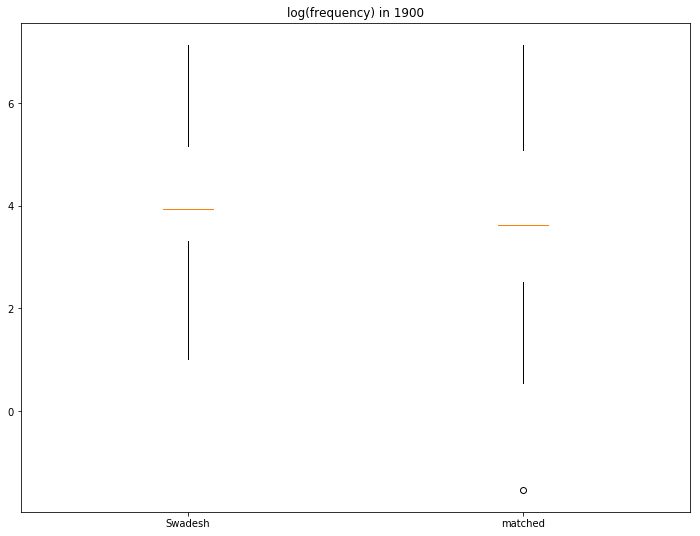

In [883]:
#change_swa = df['change'].mask(~df['is_swadesh'].astype('bool')).dropna()
#change_mat = pd.DataFrame([np.arccos(changes[w][START_YEAR]) for w in matched])
freq_mat = np.array([freqs[w][START_YEAR] for w in matched])
freq_swa = np.array([freqs[w][START_YEAR] for w in swa if w not in OMIT])
#plt.boxplot([change_swa, change_non], labels=['Swadesh', 'non-Swadesh'], showbox=False, showcaps=False)
#plt.title('Changes between 1900 and 1990')
#plt.show()

st, p = stats.ttest_ind(np.log(freq_swa*1e6), np.log(freq_mat*1e6), equal_var=False, nan_policy='omit')

print(p)

plt.boxplot([np.log(freq_swa*1e6), np.log(freq_mat*1e6)], labels=['Swadesh', 'matched'], showbox=False, showcaps=False)
plt.title('log(frequency) in 1900')
plt.show()

0.8478855452160879


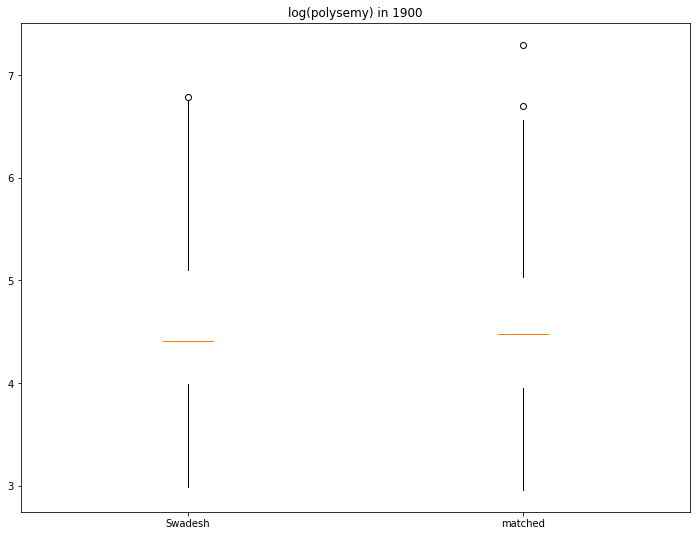

In [884]:
poly_mat = np.array([poly['bclust'][w][START_YEAR] for w in matched])
poly_swa = np.array([poly['bclust'][w][START_YEAR] for w in swa if w not in OMIT])
#plt.boxplot([change_swa, change_non], labels=['Swadesh', 'non-Swadesh'], showbox=False, showcaps=False)
#plt.title('Changes between 1900 and 1990')
#plt.show()

st, p = stats.ttest_ind(poly_swa, poly_mat, equal_var=False, nan_policy='omit')

print(p)

plt.boxplot([-np.log(poly_swa), -np.log(poly_mat)], labels=['Swadesh', 'matched'], showbox=False, showcaps=False)
plt.title('log(polysemy) in 1900')
plt.show()

0.004496163790841715


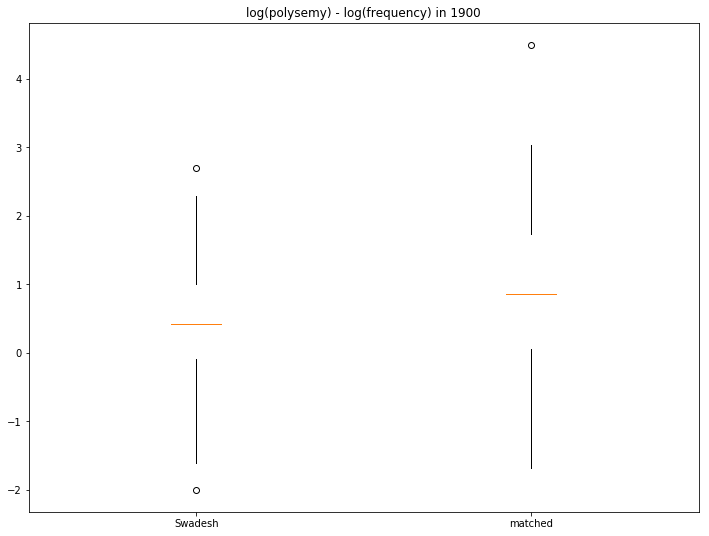

In [885]:
poly_mat = np.array([poly['bclust'][w][START_YEAR] for w in matched])
poly_swa = np.array([poly['bclust'][w][START_YEAR] for w in swa if w not in OMIT])
#plt.boxplot([change_swa, change_non], labels=['Swadesh', 'non-Swadesh'], showbox=False, showcaps=False)
#plt.title('Changes between 1900 and 1990')
#plt.show()

st, p = stats.ttest_ind(-np.log(poly_swa) - np.log(freq_swa*1e6), -np.log(poly_mat) - np.log(freq_mat*1e6), nan_policy='omit')

print(p)

plt.boxplot([-np.log(poly_swa) - np.log(freq_swa*1e6), -np.log(poly_mat) - np.log(freq_mat*1e6)], labels=['Swadesh', 'matched'], showbox=False, showcaps=False)
plt.title('log(polysemy) - log(frequency) in 1900')
plt.show()

7.66789327310931e-06


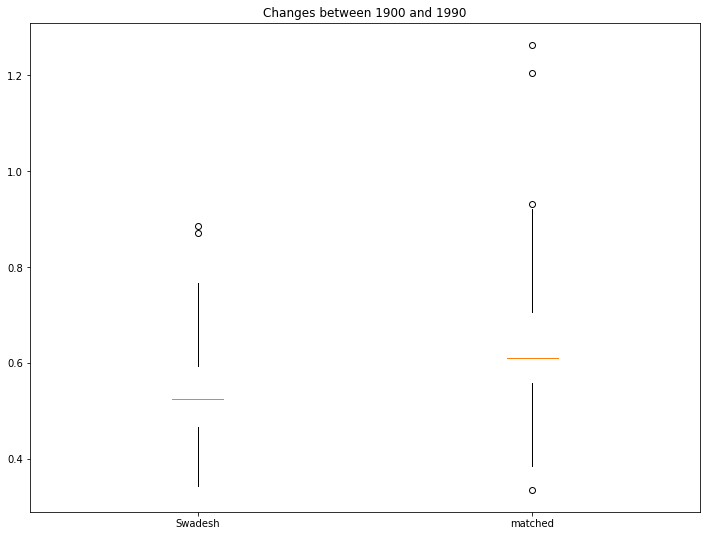

In [886]:
change_mat = np.array([np.arccos(changes[w][START_YEAR]) for w in matched])
change_swa = np.array([np.arccos(changes[w][START_YEAR]) for w in swa if w not in OMIT])
#plt.boxplot([change_swa, change_non], labels=['Swadesh', 'non-Swadesh'], showbox=False, showcaps=False)
#plt.title('Changes between 1900 and 1990')
#plt.show()

st, p = stats.ttest_ind(change_swa, change_mat, equal_var=False, nan_policy='omit')
print(p)

plt.boxplot([change_swa, change_mat], labels=['Swadesh', 'matched'], showbox=False, showcaps=False)
plt.title('Changes between 1900 and 1990')
plt.show()

# Some qualitative observations

Which words in the Swadesh list have apparently changed the most?

In [688]:
sorted(list(zip(swa, list(change_swa))), key=lambda t: t[1], reverse=True)[:5]

[('new', 0.8858179431028217),
 ('breasts', 0.8708431276426104),
 ('mouth', 0.7669193987488072),
 ('horn', 0.7514356456405993),
 ('see', 0.72475632943409)]

In [423]:
from sklearn.metrics.pairwise import pairwise_distances

vector_dir = '/home/sashkamilic/pretrained-vectors/sgns/'

word_vectors = {}

word_vectors[1900] = np.load(vector_dir + '1900-w.npy'), np.load(vector_dir + '1900-vocab.pkl')
word_vectors[1990] = np.load(vector_dir + '1990-w.npy'), np.load(vector_dir + '1990-vocab.pkl')

for w in ['new', 'breasts', 'mouth', 'horn', 'see']:
    for year in [1900, 1990]:
        print("{} in {}".format(w.upper(), year))
        vecs, vocab = word_vectors[year]
        res = pairwise_distances([vecs[vocab.index(w)]], vecs, metric='cosine')[0]
        indices = sorted(range(len(res)), key=lambda k: res[k])
        print(', '.join(np.array(vocab)[indices[:30]]))

NEW in 1900
new, york, yorkers, poughkeepsie, bridgeport, yonkers, otsego, whittaker, elizabethtown, jersey, tulane, haven, rutgers, rotherham, chicago, otago, crowell, boston, peekskill, wagnalls, albany, brooklyn, hampshire, adirondack, elmira, herkimer, newberry, 34th, greenfield, queensland
NEW in 1990
new, york, ny, huebsch, macmillan, brunswick, bramhall, wittenborn, taplinger, benziger, bronxville, larchmont, schocken, irvington, jersey, halsted, whittlesey, haven, scribner, brooklyn, islip, 10002, doubleday, braziller, vintage, duffield, elek, praeger, schirmer, albany
BREASTS in 1900
breasts, bosoms, breast, hearts, rankling, nourished, mothers, bosom, nipples, beatings, thighs, tingled, livers, sicknesses, tunics, chins, bedewed, loins, kindliest, knits, entwined, swelled, skinny, coronets, womb, foreheads, bared, gnashed, freckles, instilling
BREASTS in 1990
breasts, thighs, hips, buttocks, breast, chest, cheeks, waist, cheek, abdomen, clasped, belly, shoulders, softness, bo